# Network Analysis

Network analysis can be utilized to understand communication patterns between employees.
Building an email network is helpful with network analysis to visualize communication between individuals 
by creating a graph with representation for each employee and email communication. 
When developing a network analysis measurements of network distribution will be important 
to identify to determine how nodes and edges are distributed in a network. 
This includes the important theory of betweenness centrality, which can show which
nodes are likely pathways of information and what employees would act as bridges to facilitate
communication for wrongdoing acts.
With use of the Python package, NetworkX, creation and analysis can be performed for complex networks. 
Email networks can help
uncover key individuals, groups and relationships.

- `nxviz`
- `G = nx.from_pandas_dataframe(data, 'sender', 'recipient1', edge_attr=['date', 'subject'])`
- `nxviz.ArcPlot`
- `nxviz.CircosPlot`
- `networkx.draw_networkx(G, networkx.spring_layout(G, k=0.1), node_size=25, node_color='red', with_labels=True, edge_color='blue'))`
    - `k` or spring tension in `spring_layout` changes the visualization (small k is more useful)
- Degree Centrality
- Betweenness Centraility

[Kaggle - Enron Network Analysis](https://www.kaggle.com/code/jamestollefson/enron-network-analysis)

- Anomaly Detection, Social Network Analysis, Email Body Analysis

[Enron-Email-Analysis](https://github.com/mihir-m-gandhi/Enron-Email-Analysis)

[Network Analysis with the Enron Email Corpus](https://www.tandfonline.com/doi/pdf/10.1080/10691898.2015.11889734)
[Exploration of Communication Networks from the Enron Email Corpus](http://www.casos.cs.cmu.edu/publications/protected/2005-2006/diesner_2005_explorationsenron.pdf)


Social Network Analysis

Refer to the Python package `networkx` for information on network analysis in Python [1].
Good examples of social network analysis with Python in [2].

- Pre-Processing:
    - Load the dataset
    - Clean Data: Remove any emails with missing information, irrelevant emails, etc.
- Build Network
    - Directed Graph: e.g., sender and recipient represent the nodes, and each email is a directed edge from sender to recipient
    - Analyze Network Properties: Centrality bar charts (Refer to [2])
        - Degree Centrality: Identify individuals who sent or received the most emails.
        - Betweenness Centrality: Identify key individuals who serve as intermediaries.
        - Closeness Centrality: Find individuals who are closest to others on average.
        - Eigenvector Centrality: Help identify key figures who are well-connected to other influential individuals, providing deeper insight into the power dynamics within the Enron network.
            - High Eigenvector Centrality: Individuals with high scores are not only well-connected but connected to other influential people in the network. 
            These could represent core members of critical communication networks or leaders in the organization.
            - Low Eigenvector Centrality: Individuals with low scores are likely either peripheral or isolated in the network or are only connected to others with similarly low influence.
- Additional Network Ideas:
    - Detect Communities: Community detection algorithms (e.g., Girvan-Newman) to find groups within the network.
    - Analyze Clusters: Investigate clusters within the network to understand isolated teams or departments.
- Visualize Network:
    - Color-code communities or size nodes by centrality for
    - Extra detail for more information: Color-code communities or size nodes by centrality
- Reference NetworkX: [bibtex](http://conference.scipy.org.s3-website-us-east-1.amazonaws.com/proceedings/scipy2008/paper_2/reference.bib)

[1](https://networkx.org/documentation/stable/index.html)
[2](https://link.springer.com/book/10.1007/978-3-319-53004-8)

In [7]:
import numpy as np
import pandas as pd
import re
import sqlite3
import matplotlib.pyplot as plt
# NLP with the LDA model for topic modeling
from gensim.corpora import Dictionary
from gensim.models import LdaSeqModel
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from bs4 import BeautifulSoup

In [5]:
# Connect to the database (or create it if it doesn't exist)
connection = sqlite3.connect("../data/emails_processed.db")

# Create a cursor object to execute SQL commands
cursor = connection.cursor()

# Load the dataframe from the SQLite database
emails_df = pd.read_sql_query("SELECT * FROM emails_processed", connection)

# Close the connection
connection.close()

# Show email data
emails_df.head()

,text,message_id,date,from,to,subject,cc,bcc,mime-version,content-type,...,x-bcc,folder,origin,filename,priority,processed_text,tokens,stripped_date,datetime,dominant_topic
0,---------------------- Forwarded by Rika Imai/...,<88180.1075863689140.JavaMail.evans@thyme>,"Tue, 8 May 2001 08:37:00 -0700 (PDT)",rika.imai@enron.com,"john.forney@enron.com, mike.carson@enron.com, ...",4 Month Rolling Forecast,,,1.0,text/plain; charset=ANSI_X3.4-1968,...,,\Rob_Benson_Jun2001\Notes Folders\Notes inbox,Benson-R,rbenson.nsf,normal,forwarded by rika imainaenron on pm dan sal...,"[""['forward',"", ""'rika',"", ""'imainaenron',"", ""...","Tue, 8 May 2001 08:37:00",2001-05-08 08:37:00,8
1,great,<4460514.1075857469666.JavaMail.evans@thyme>,"Wed, 21 Jun 2000 02:01:00 -0700 (PDT)",hunter.shively@enron.com,richard.tomaski@enron.com,Re: Jim Simpson,,,1.0,text/plain; charset=us-ascii,...,,\Hunter_Shively_Jun2001\Notes Folders\Sent,Shively-H,hshivel.nsf,normal,great,"[""['great']""]","Wed, 21 Jun 2000 02:01:00",2000-06-21 02:01:00,6
2,"oohh la la. who was your ""friend""? did you g...",<2160301.1075858147494.JavaMail.evans@thyme>,"Wed, 16 Aug 2000 03:03:00 -0700 (PDT)",matthew.lenhart@enron.com,shelliott@dttus.com,Re: Re[2]:,,,1.0,text/plain; charset=us-ascii,...,,\Matthew_Lenhart_Jun2001\Notes Folders\Sent,Lenhart-M,mlenhar.nsf,normal,oohh la la who was your friend did you guys ...,"[""['oohh',"", ""'la',"", ""'la',"", ""'friend',"", ""'...","Wed, 16 Aug 2000 03:03:00",2000-08-16 03:03:00,2
3,\nAttached are the two files with this week's ...,<22847680.1075863611080.JavaMail.evans@thyme>,"Wed, 15 Aug 2001 05:46:47 -0700 (PDT)",rika.imai@enron.com,"russell.ballato@enron.com, hicham.benjelloun@e...",FW: Nuclear Rolling Forecast,,,1.0,text/plain; charset=us-ascii,...,,"\ExMerge - Benson, Robert\Inbox\Large Messages",BENSON-R,rob benson 6-25-02.PST,normal,attached are the two files with this weeks nuc...,"[""['attach',"", ""'two',"", ""'file',"", ""'week',"",...","Wed, 15 Aug 2001 05:46:47",2001-08-15 05:46:47,5
4,lm:\nWhat are your thoughts going forward........,<15012282.1075852957298.JavaMail.evans@thyme>,"Wed, 3 Oct 2001 00:35:05 -0700 (PDT)",jennifer.fraser@enron.com,larry.may@enron.com,hello,,,1.0,text/plain; charset=us-ascii,...,,\LMAY2 (Non-Privileged)\Inbox,May-L,LMAY2 (Non-Privileged).pst,normal,lmwhat are your thoughts going forward also wh...,"[""['lmwhat',"", ""'thought',"", ""'go',"", ""'forwar...","Wed, 3 Oct 2001 00:35:05",2001-10-03 00:35:05,0


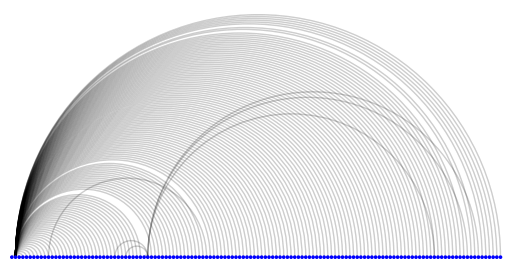

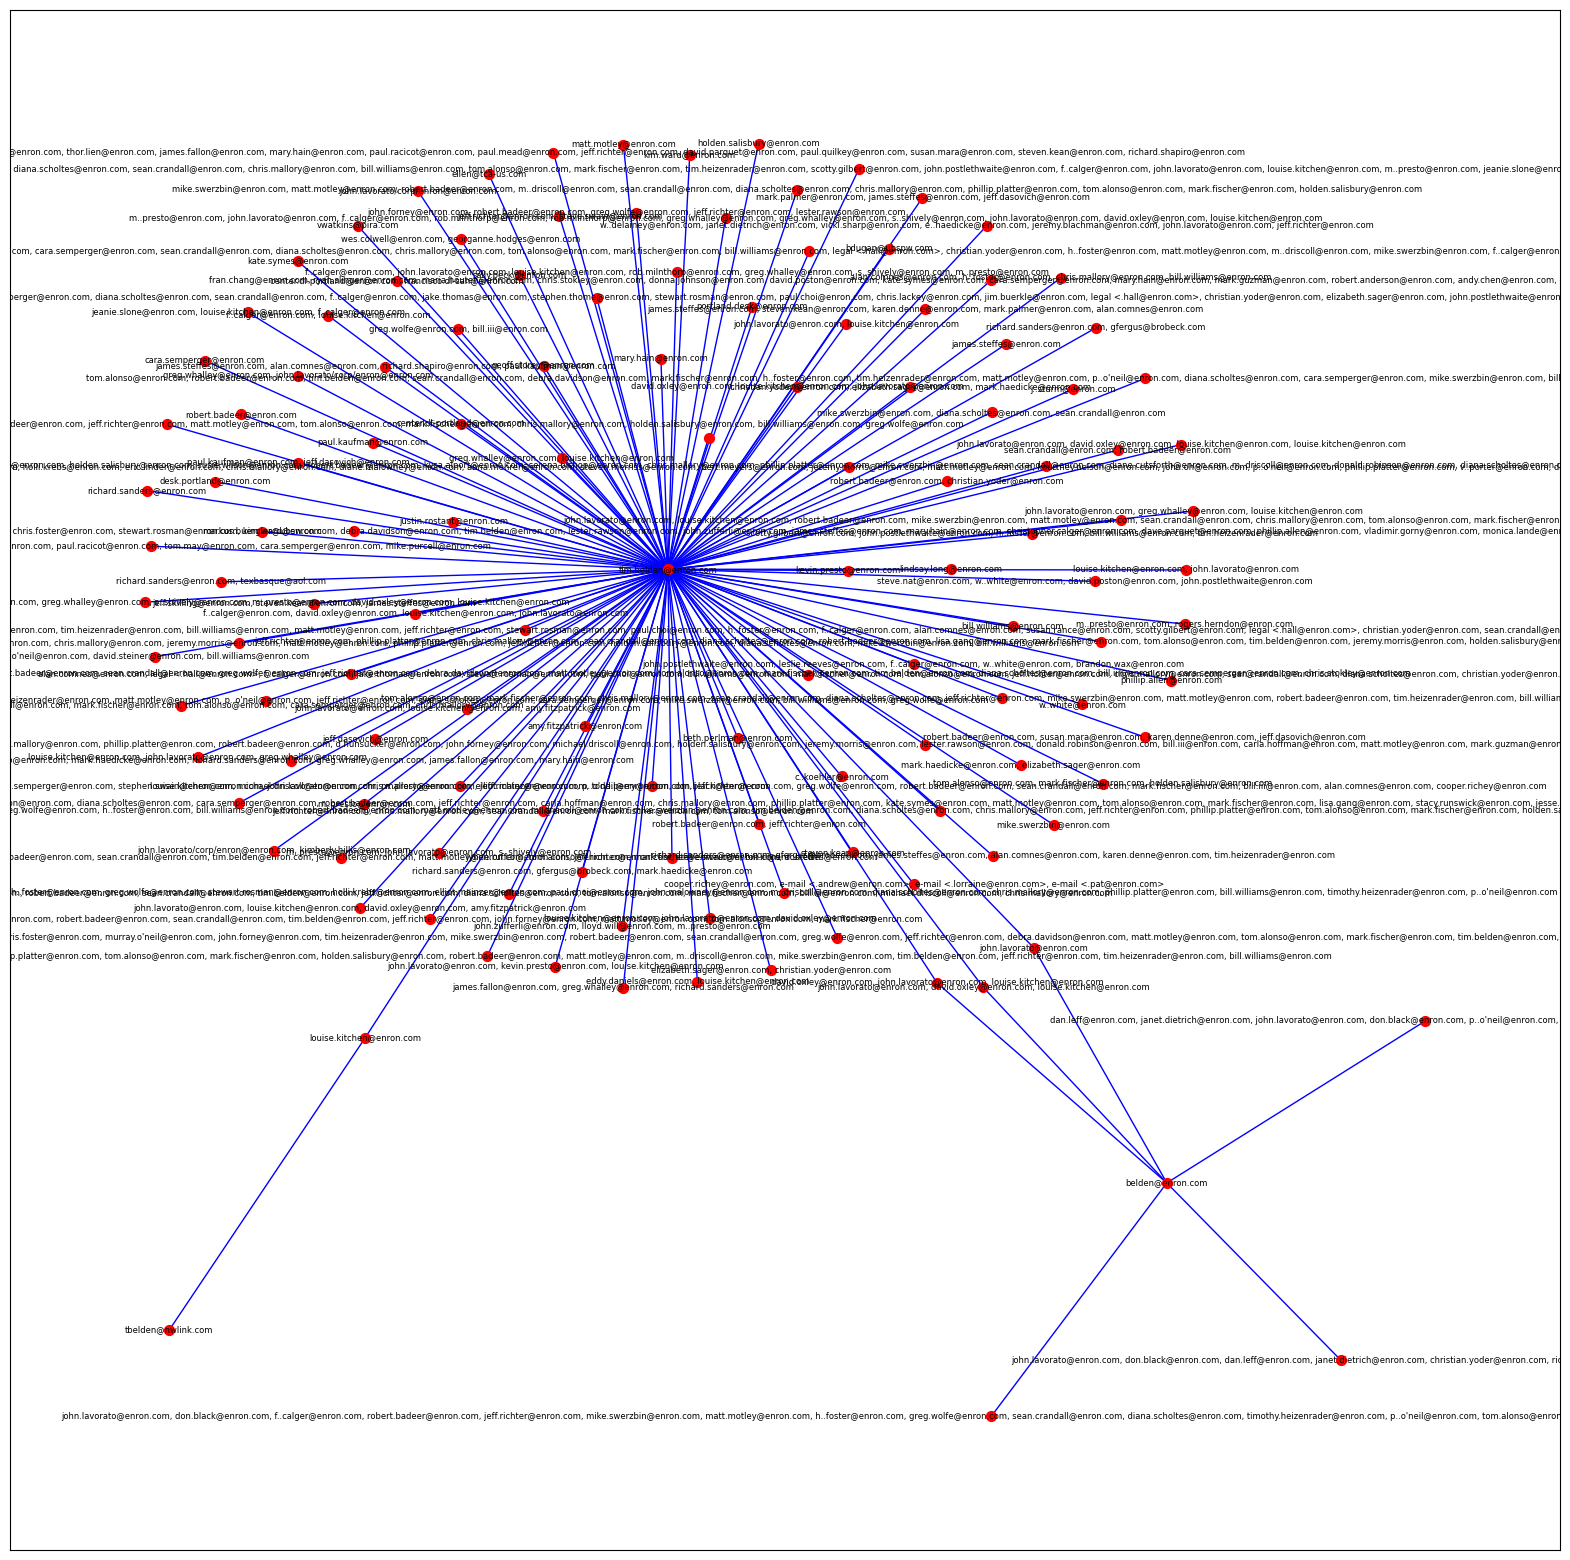

In [13]:
import networkx as nx
import nxviz as nv
import matplotlib.pyplot as plt

# Filter emails
tim_emails_df = emails_df[
    emails_df["from"].str.contains(r"belden", regex=True, na=False)
]

# Create graph
G = nx.from_pandas_edgelist(tim_emails_df, 'to', 'from', edge_attr=['date', 'subject'])

# Plot using ArcPlot
plot = nv.ArcPlot(G)
plt.figure(figsize=(20, 20))

# Use a different layout to reduce overlap
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Draw the graph
nx.draw_networkx(
    G, pos, node_size=50, node_color='red', with_labels=True, edge_color='blue', font_size=6
)

# Show plot
plt.show()

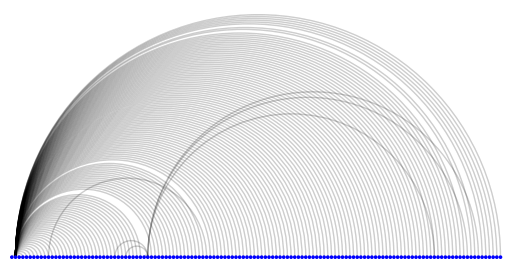

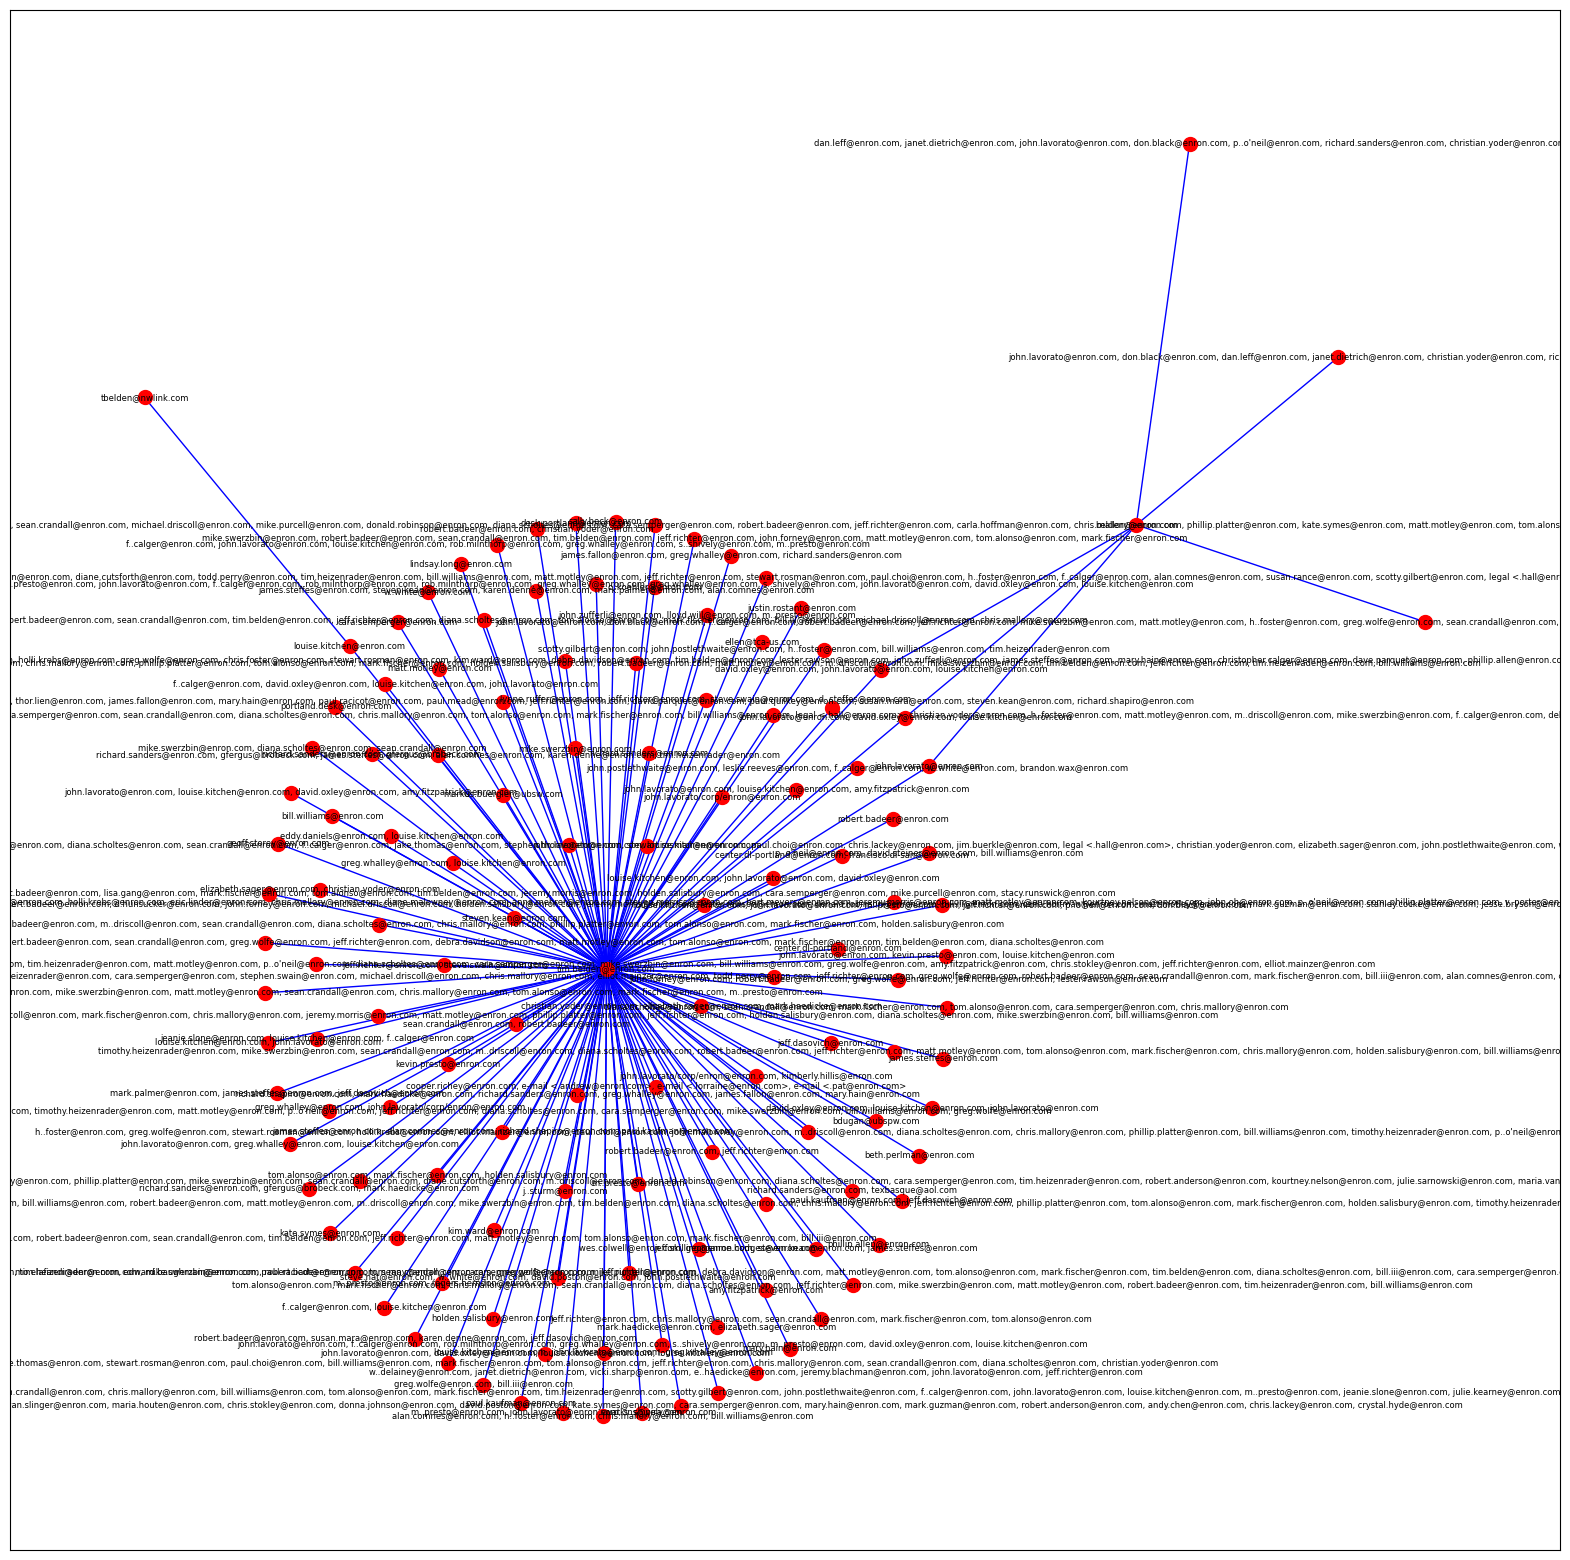

In [12]:
import networkx as nx
import nxviz as nv
import matplotlib.pyplot as plt

# Filter emails
tim_emails_df = emails_df[
    emails_df["from"].str.contains(r"belden", regex=True, na=False)
]

# Create graph
G = nx.from_pandas_edgelist(tim_emails_df, 'to', 'from', edge_attr=['date', 'subject'])

# Plot using ArcPlot
plot = nv.ArcPlot(G)
plt.figure(figsize=(20, 20))

# Use Kamada-Kawai layout to reduce overlap
pos = nx.kamada_kawai_layout(G)

# Draw the graph
nx.draw_networkx(
    G, pos, node_size=100, node_color='red', with_labels=True, edge_color='blue', font_size=6
)

# Show plot
plt.show()